In [1]:
import glob
from skimage import io
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from image_funcs import *
import skimage
import peakutils
import cv2
from tqdm import tqdm  
import imageio
import re
import os
import time
from pystackreg import StackReg
from skimage.util import img_as_uint
import gc

In [2]:
directory = "/mnt/n/PAULSSON LAB/Somenath/DATA_Ti4/20190317--B_Subtilis_Exit--BACKUP/B_subtilis_EXIT_NO_FLOW_extracted/TIFFs/"
output_directory = "/mnt/n/PAULSSON LAB/Somenath/DATA_Ti4/20190317--B_Subtilis_Exit--BACKUP/B_subtilis_EXIT_NO_FLOW_extracted/extracted/"
try:
    os.mkdir(output_directory)
except:
    pass

phase_channel = "Phase"
other_channels = []

make_diagnostic_directories(output_directory)

FOVs = get_FOVs(directory, phase_channel, 3)

In [26]:
## This is destructive! 
## Avoid running it more than once! 
## Please re-extract the TIFFs from the ND2 file before proceeding if you accidentally run this twice. 
for FOV in FOVs:
    register_transform_save_FOV(directory, FOV, phase_channel, other_channels)
    gc.collect()

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]                                  
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/nikon/anaconda3/envs/extraction/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/nikon/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 567, in run
    self.flag_executor_shutting_down()
  File "/home/nikon/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 756, in flag_executor_shutting_down
    self.kill_workers()
  File "/home/nikon/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 766, in kill_workers
    recursive_terminate(p)
  File "/home/nikon/.local/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/nikon/.local/lib/python3.6/site-packages/joblib/externals/loky/backend/ut

KeyboardInterrupt: 

In [27]:
double_mm = 0
FOVs = get_FOVs(directory, phase_channel, 3)
a = 0
for FOV in FOVs:
    initial_image = get_image_list(directory,FOV, phase_channel)[0]
    image = io.imread(initial_image)
    if a == 0:
        rotation = get_orientation(image, debug = False)
    fixed_image = fix_orientation(image, rotation)
    fixed_image = img_as_uint(fixed_image)
    cv2.imwrite(output_directory + "diagnostics/rotations/{}.tif".format(FOV), fixed_image, [cv2.IMWRITE_TIFF_COMPRESSION, 1])
    if double_mm == 1:
        top_half, bottom_half = get_img_half(image,"top"), get_img_half(image,"bottom")
        bottom_half = img_as_uint(skimage.transform.rotate(bottom_half, 180))
        cv2.imwrite(output_directory + "diagnostics/top_split/{}.tif".format(FOV), top_half, [cv2.IMWRITE_TIFF_COMPRESSION, 1])
        cv2.imwrite(output_directory + "diagnostics/bottom_split/{}.tif".format(FOV), bottom_half, [cv2.IMWRITE_TIFF_COMPRESSION, 1])
    a +=1


KeyboardInterrupt: 

409


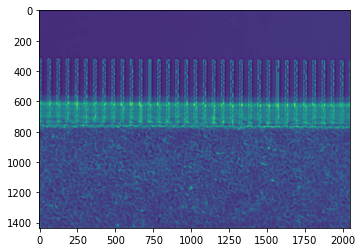

In [7]:
image = imageio.imread(directory+"xy003_T0001_Phase.tif")
print(int(image.shape[0]*0.2))
plt.imshow(image[int(image.shape[0]*0.3):,])

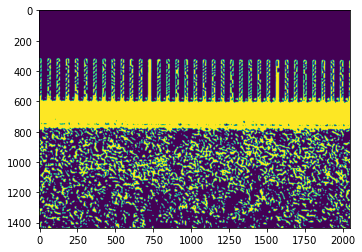

In [18]:
test_image = image
bin_image = test_image > threshold_li(test_image) * 1

cropped_bin = bin_image[int(bin_image.shape[0]*0.3):,]
plt.imshow(cropped_bin)
y_mean_intensity = np.mean(cropped_bin, axis=1)
top_threshold = np.mean(y_mean_intensity)/1
bottom_threshold = np.max(y_mean_intensity)/2
top_threshold_line = np.argmax(y_mean_intensity > top_threshold) - 10
bottom_threshold_line = np.argmax(y_mean_intensity > bottom_threshold)-10

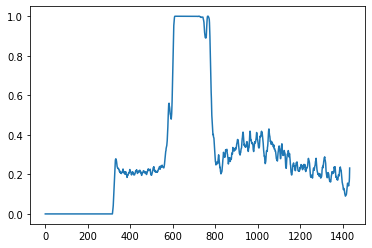

In [19]:
plt.plot(y_mean_intensity)

In [20]:
bottom_threshold_line

569

In [3]:
rotation = -0.33
double_mm = 0
a = 0
trench_positions = {}
for FOV in FOVs:
    initial_image = get_image_list(directory,FOV, phase_channel)[0]
    image = io.imread(initial_image)
    if double_mm == 1:
        top_half, bottom_half = get_img_half(image,"top"), get_img_half(image,"bottom")
        bottom_half = img_as_uint(skimage.transform.rotate(bottom_half, 180))
        trench_positions["{}_top".format(FOV)] =  get_trenches(top_half, rotation, FOV, "top")
        trench_positions["{}_bottom".format(FOV)] = get_trenches(bottom_half, rotation, FOV, "bottom")
    elif double_mm == 0:
        trench_positions["{}".format(FOV)] = get_trenches(
            image = image, 
            rotation = rotation,
            FOV =  FOV, 
            top_bottom = None, 
            output_directory = output_directory, 
            min_dist = 40, 
            thres = 1.4, 
            top_thres_multiplier = 1.5, 
            bottom_thres_multiplier = 2)


In [15]:
split_FOVs = list(trench_positions.keys())
try:
    os.mkdir(output_directory + "trenches/")
except:
    pass
for split_FOV in split_FOVs:
    try:
        os.mkdir(output_directory + "trenches/" + split_FOV)
    except:
        pass
    try:
        os.mkdir(output_directory + "trenches/" + split_FOV + "/" + phase_channel)
    except:
        pass
    for x in range(len(trench_positions[split_FOV][2])):
        try:
            os.mkdir(output_directory + "trenches/" + split_FOV + "/" + phase_channel + "/" + "trench_{}".format(str(x).zfill(2)))
        except:
            pass
    for channel in other_channels:
        try:
            os.mkdir(output_directory + "trenches/" + split_FOV + "/" + channel)
        except:
            pass
        for x in range(len(trench_positions[split_FOV][2])):
            try:
                os.mkdir(output_directory + "trenches/" + split_FOV + "/" + channel + "/" + "trench_{}".format(str(x).zfill(2)))
            except:
                pass

In [16]:
Parallel(n_jobs=-1)(delayed(extract_and_save_trenches)(FOV = FOV,
                                                       double_mm =  0, 
                                                       directory = directory,
                                                       output_directory = output_directory, 
                                                       phase_channel = phase_channel, 
                                                       other_channels = [], 
                                                       trench_positions = trench_positions,
                                                       rotation = 0
                                                      ) for FOV in tqdm(FOVs))

100%|██████████| 10/10 [00:00<00:00, 586.18it/s]


[None, None, None, None, None, None, None, None, None, None]

In [7]:
try:
    os.mkdir(output_directory + "kymographs/")
except:
    pass
for split_FOV in split_FOVs:
    try:
        os.mkdir(output_directory + "kymographs/" + split_FOV)
    except:
        pass
    try:
        os.mkdir(output_directory + "kymographs/" + split_FOV + "/" + phase_channel)
    except:
        pass
    for channel in other_channels:
        try:
            os.mkdir(output_directory + "kymographs/" + split_FOV + "/" + channel)
        except:
            pass

In [9]:
Parallel(n_jobs=-1)(delayed(extract_and_save_kymographs)(FOV,
                                                        output_directory = output_directory,
                                                        phase_channel = phase_channel,
                                                        other_channels = []) for FOV in tqdm(split_FOVs))

100%|██████████| 10/10 [00:00<00:00, 140.58it/s]


[None, None, None, None, None, None, None, None, None, None]